In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torchaudio
import aubio
import os
import matplotlib.pyplot as plt


In [17]:
%run MIDI_scales.ipynb

{'Enigmatic': [0, 1, 4, 6, 8, 10, 11], 'Diminished': [0, 2, 3, 5, 6, 8, 9, 11], 'Melodic Minor': [0, 2, 3, 5, 7, 9, 11], 'Phrygian': [0, 1, 3, 5, 7, 8, 10], 'Harmonic Minor': [0, 2, 3, 5, 7, 8, 11], 'Ionian': [0, 2, 4, 5, 7, 9, 11], 'Dorian': [0, 2, 3, 5, 7, 9, 10], 'Neapolitan': [0, 1, 3, 5, 7, 9, 11], 'Major Bebop': [0, 2, 4, 5, 7, 8, 9, 11], 'Whole Tone': [0, 2, 4, 6, 8, 10], 'Minor': [0, 2, 3, 5, 7, 8, 10], 'Blues': [0, 3, 5, 6, 7, 10], 'Arabic': [0, 1, 4, 5, 7, 8, 11], 'Lydian': [0, 2, 4, 6, 7, 9, 11], 'Dominant Bebop': [0, 2, 4, 5, 7, 9, 10, 11], 'Pentatonic Major': [0, 2, 4, 7, 9], 'Mixolydian': [0, 2, 4, 5, 7, 9, 10], 'Neapolitan Minor': [0, 1, 3, 5, 7, 8, 11], 'Major': [0, 2, 4, 5, 7, 9, 11], 'Diatonic': [0, 2, 4, 7, 9], 'Japanese Insen': [0, 1, 5, 7, 10], 'Pentatonic Blues': [0, 3, 5, 6, 7, 10], 'Pentatonic Minor': [0, 3, 5, 7, 10]}


In [18]:
os.chdir('../ML Corpus 2/')
cd = os.getcwd()      


filenames = []

for (root,dirs,files) in os.walk(cd, topdown=True): 
    for name in files:
          if name.endswith('.'+'wav'):
            filenames.append(os.path.join(root, name))

In [19]:
def audio_One_Hot(filenames, seq_len=16):
    """
    Extract MIDI notes from audio files and prepare one-hot encoded sequences for RNN training.

    Args:
        filenames (list): List of audio file paths.
        seq_len (int): Sequence length for training data.

    Returns:
        torch.Tensor: Input sequences (X), shape (num_sequences, seq_len, 127).
        torch.Tensor: Target sequences (y), shape (num_sequences, seq_len).
    """
    downsample = 1
    samplerate = 44100 // downsample
    win_s = 512 // downsample  # FFT size
    hop_s = 256 // downsample  # Hop size
    notes = []

    for file in filenames:
        # Load audio file
        s = aubio.source(file, samplerate, hop_s)
        samplerate = s.samplerate

        notes_o = aubio.notes("default", win_s, hop_s, samplerate)

        # Extract MIDI notes
        while True:
            samples, read = s()
            new_note = notes_o(samples)
            if new_note[0] != 0:  # Only consider non-zero notes
                notes.append(int(new_note[0]))  # Append MIDI note as an integer
            if read < hop_s:
                break
    print("MIDI range:", min(notes),"-", max(notes))
    # Prepare sequences
    X, y = [], []
    for i in range(0, len(notes) - seq_len):
        input_seq = notes[i:i + seq_len]
        target_seq = notes[i + 1:i + seq_len + 1]

        # One-hot encode input sequence
        input_one_hot = torch.zeros(seq_len, 127)
        for t, note in enumerate(input_seq):
            input_one_hot[t, note] = 1  # One-hot encode the note

        X.append(input_one_hot)
        y.append(torch.tensor(target_seq))  # Targets are class indices

    X = torch.stack(X)  # Shape: (num_sequences, seq_len, 127)
    y = torch.stack(y)  # Shape: (num_sequences, seq_len)

    return X, y

In [20]:
X, y = audio_One_Hot(filenames)
print(X.shape, y.shape)

MIDI range: 46 - 117
torch.Size([3457, 16, 127]) torch.Size([3457, 16])


In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)  # Output shape: (batch_size, seq_len, output_size)
        return out

input_size = 127
hidden_size = 20
output_size = 127
model = SimpleRNN(input_size, hidden_size, output_size)

In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X)  # Shape: (batch_size, seq_len, output_size)
    outputs = outputs.transpose(1, 2)  # Shape: (batch_size, output_size, seq_len) for CrossEntropyLoss
    loss = criterion(outputs, y)  # Targets (y) are shape (batch_size, seq_len)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 4.7745
Epoch [20/500], Loss: 4.6802
Epoch [30/500], Loss: 4.5417
Epoch [40/500], Loss: 4.3555
Epoch [50/500], Loss: 4.1701
Epoch [60/500], Loss: 4.0273
Epoch [70/500], Loss: 3.9301
Epoch [80/500], Loss: 3.8638
Epoch [90/500], Loss: 3.8173
Epoch [100/500], Loss: 3.7845
Epoch [110/500], Loss: 3.7604
Epoch [120/500], Loss: 3.7417
Epoch [130/500], Loss: 3.7260
Epoch [140/500], Loss: 3.7120
Epoch [150/500], Loss: 3.6990
Epoch [160/500], Loss: 3.6863
Epoch [170/500], Loss: 3.6735
Epoch [180/500], Loss: 3.6603
Epoch [190/500], Loss: 3.6460
Epoch [200/500], Loss: 3.6306
Epoch [210/500], Loss: 3.6151
Epoch [220/500], Loss: 3.6002
Epoch [230/500], Loss: 3.5859
Epoch [240/500], Loss: 3.5716
Epoch [250/500], Loss: 3.5559
Epoch [260/500], Loss: 3.5379
Epoch [270/500], Loss: 3.5182
Epoch [280/500], Loss: 3.4981
Epoch [290/500], Loss: 3.4774
Epoch [300/500], Loss: 3.4563
Epoch [310/500], Loss: 3.4348
Epoch [320/500], Loss: 3.4126
Epoch [330/500], Loss: 3.3895
Epoch [340/500], Lo

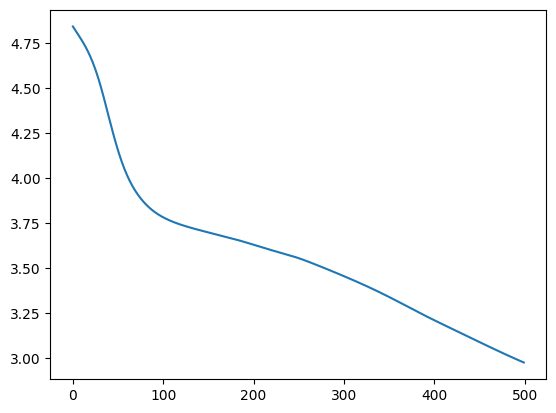

In [23]:
plt.plot(losses)
plt.show()

In [24]:
def generate_note_sequence(model, start_sequence, length, temperature=1.0, device="cpu"):
    """
    Generates a new MIDI note sequence using a trained RNN with stochastic sampling.

    Args:
        model (nn.Module): Trained RNN model.
        start_sequence (list): List of initial MIDI notes to start generation.
        length (int): Total length of the sequence to generate.
        temperature (float): Temperature for softmax scaling (controls randomness).
        device (str): Device to run the model on ("cpu" or "cuda").

    Returns:
        list: Generated MIDI note sequence.
    """
    model.eval()  # Set the model to evaluation mode

    # One-hot encode the start sequence
    seq_len = len(start_sequence)
    input_seq = torch.zeros(1, seq_len, 127).to(device)  # Shape: (batch_size=1, seq_len, input_size)
    for t, note in enumerate(start_sequence):
        input_seq[0, t, note] = 1

    # Initialize the generated sequence with the start sequence
    generated_sequence = start_sequence[:]

    with torch.no_grad():
        for _ in range(length):
            # Pass the current input sequence to the model
            output = model(input_seq)  # Shape: (1, seq_len, 127)

            # Get the last time step's output (logits for next note)
            logits = output[0, -1]  # Shape: (127,)

            # Apply temperature scaling to logits
            scaled_logits = logits / temperature

            # Convert logits to probabilities using softmax
            probabilities = torch.softmax(scaled_logits, dim=0)

            # Sample the next note using a multinomial distribution
            next_note = torch.multinomial(probabilities, num_samples=1).item()

            # Append the predicted note to the generated sequence
            generated_sequence.append(next_note)

            # Update the input sequence with the new note
            new_one_hot = torch.zeros(1, 1, 127).to(device)
            new_one_hot[0, 0, next_note] = 1
            input_seq = torch.cat((input_seq[:, 1:, :], new_one_hot), dim=1)  # Slide window

    return generated_sequence


In [80]:
# Define your initial MIDI note sequence (e.g., a short melody or random notes)
start_sequence = [42]

# Generate a new sequence
generated_sequence = generate_note_sequence(
    model=model,               
    start_sequence=start_sequence,
    length=16,                 
    temperature=0.8,
    device="cpu"               
)
for i, note in enumerate(generated_sequence):
    generated_sequence[i] = quantiser(note,scales.get('Neapolitan'))

print("Generated MIDI Sequence:", generated_sequence)
client.send_message('/sequence', generated_sequence)

Generated MIDI Sequence: [41, 84, 55, 61, 53, 47, 51, 101, 113, 67, 69, 61, 61, 49, 51, 47, 48]


In [30]:
from pythonosc import dispatcher
from pythonosc import udp_client
from pythonosc import osc_server

In [31]:
client = udp_client.SimpleUDPClient('127.0.0.1', 8002)

In [37]:
client.send_message('/sequence', generated_sequence)

AttributeError: '_cython_3_0_5.cython_function_or_method' object has no attribute '_check_port'